# Project: Twitter Archive of WeRateDogs 

# Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<br>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
        <li><a href="#gather">Part I. Gathering Data</a></li>
        <li><a href="#access">Part II. Accessing Data</a></li>
            <ul>
                <li><a href="#quality">Data Quality and Tidiness</a></li>
            </ul>
        <li><a href="#clean">Part III. Cleaning Data</a></li>
        <li><a href="#store">Part IV. Storing Data</a></li>
    </ul>
<br>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
        <li><a href="#visual">Part V.Analyzing and Visualizations</a></li>
    </ul>
<br>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Introduction

> In this project, the dataset I analyze is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). This twitter account rates people's dogs with ratings on denominator of 10 along with comments. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of tweets from August 1, 2017. 



> The objective of this project is wrangling WeRateDog Twitter data to draw interesting and trustworthy analyses and visualizations . The main focus on my project is performing data wrangling from a variety of sources and in variety of formats, in the process of gathering, accessing and cleaning using Python and its libiraries. 


> Introducing three datasets: 
<br>
- Twittwer Archive. Originally the enhanced Twitter archive contains 5000+ tweets with basic tweet data. It is being filtered for tweets with ratings only along with information like dog name, stage, etc. 
- Image Prediction. This dataset is created by running every image in the WeRateDogs Twitter Archive through a neural network that can classify top three predictions(corresponding to the most confident predictions) on breeds of dogs alongside each tweet ID, image URL and the image number.
- Retweets and Favorites.Querying from Twitter's API, this dataset generates retweet count and favorite count of each tweet ID in WeRateDogs Twitter Archive.

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import re
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='wrangling'></a>
# Data Wrangling

<a id='gather'></a>
## Part I. Gathering Data

1.a archive: WeRateDogs Twitter Archive dataset, which is given on hand. Use 'read_csv' to read data. 

1.b image: Image Predictions dataset, which is hosted on Udacity's servers. Download programmatically using the requests library.

1.c tweets_data: Retweet count and favorite count dataset, which is generated by querying Twitter's API.

In [2]:
# 1.a Read WeRateDogs archive data. 
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# 1.b Use request library to read image prediction data.
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

# Read tsv data
image = pd.read_csv('image_predictions.tsv', delimiter = '\t')

In [4]:
1.c Use Tweepy to query API 
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True,wait_on_rate_limit_notify = True)

In [5]:
Write JSON data into tweet_json.txt
with open('tweet_json.txt', 'a', encoding = 'utf8') as f:
    for tweet_id in archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

In [6]:
# Create a empty list for append each tweet info into it
tweets_data = []

tweet_json = open('tweet_json.txt', 'r')

for line in tweet_json:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
    
tweet_json.close()

In [7]:
print(tweets_data[0])

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'display_text_range': [0, 85], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}, 'extended_entities': {'media

In [8]:
tweets = pd.DataFrame()

tweets['id'] = list(map(lambda tweet: tweet['id'],tweets_data))
tweets['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'],tweets_data))
tweets['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'],tweets_data))

tweets.head()

,id,retweet_count,favorite_count
0,892420643555336193,8159,37470
1,892177421306343426,6040,32198
2,891815181378084864,3997,24272
3,891689557279858688,8312,40784
4,891327558926688256,9007,39005


<a id='access'></a>
# Part II. Accessing Data

Properties of data include Quality and Tideness.

Quality (issues with content) Dimensions:

- Completeness

- Validity

- Accuracy

- Consistency


Tidiness (issues with structure) Dimensions:

- Each variable forms a column

- Each observation forms a row

- Each type of observational unit forms a table




In [9]:
# check information, head and tail of archive.
archive.info()
archive.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
archive.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [11]:
# check ratings on denominator and numerator.
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
# Retweet in archive is not considered, so check numbers of retweets.
archive.retweeted_status_id.isna().value_counts()

True     2175
False     181
Name: retweeted_status_id, dtype: int64

In [14]:
archive.in_reply_to_status_id.isna().value_counts()

True     2278
False      78
Name: in_reply_to_status_id, dtype: int64

In [15]:
# Check if there are missing values in expanded_urls, which means tweets do not included an image.
archive.expanded_urls.isnull().value_counts()                

False    2297
True       59
Name: expanded_urls, dtype: int64

In [16]:
# check information, head of image.
image.info()
image.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [17]:
# Check if all tweet_id has images.
image.img_num.isnull().value_counts()

False    2075
Name: img_num, dtype: int64

In [18]:
# Check information and head of tweets.
tweets.info()
tweets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
id                2335 non-null int64
retweet_count     2335 non-null int64
favorite_count    2335 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


,id,retweet_count,favorite_count
0,892420643555336193,8159,37470
1,892177421306343426,6040,32198
2,891815181378084864,3997,24272
3,891689557279858688,8312,40784
4,891327558926688256,9007,39005


In [19]:
# Check if there are duplicates in three datasets.
print(archive.duplicated().value_counts())
print(image.duplicated().value_counts())
print(tweets.duplicated().value_counts())

False    2356
dtype: int64
False    2075
dtype: int64
False    2335
dtype: int64


In [20]:
# Check the length of three datasets to see if the tweet counts match. 
print('archive counts = {}'.format(len(archive)))
print('image counts = {}'.format(len(image)))
print('tweets data count = {}'.format(len(tweets_data)))

archive counts = 2356
image counts = 2075
tweets data count = 2335


<a id='quality'></a>
# Quality:

- archive: Including 181 retweets and 78 replies that are unnessary. (#1)
- archive: 'expanded_url' has missing values. That means it doesn't include an image. The ratings will not be considered without images. (#2)
- archive: 'rating_denominator' column has value not equal to 10. (#3)
- archive: 'rating_numerator' column has unexpected value. (#4)
- archive: Data type for timestamp is not correct. (#5)
- archive: 'source' column is not clean. (#6)
- image: Dog breed names have delimiter that need to be cleaned. Name should be caplitalized. (#8)
- tweets: Data type for retweet_count and favorite_count should be integer. (#9)
- Counts of tweets are inconsistent in three dataset. (#10)

## Tidiness:
- archive: 'doggo','floofer','pupper','puppo' columns refer to four categories of dog stage, that should be under one column: 'dog_stage'. (#7)
- image: Aggregate p1, p2 and p3 to classify each image into dog_type(Dog, Might Dog and Not Dog), dog_breed(with best confidence). (#8)
- tweets: This can be merged to archive data. Three dataset should be merged into one final dataset. (#10)

> Note: The following Cleaning process is following a logical order instead of the order of issue statement above. Following cleaning includes solving multiple issues at one step, which makes it easier to follow. The final dataset will reflect all issues being resolved.

<a id='clean'></a>
# Part III. Cleaning Data

In [21]:
# Make copies of original dataset.
archive_clean = archive.copy()
image_clean = image.copy()
tweets_clean = tweets.copy()

## (1) Define

Archive: Retweets are not considered. Delete the 151 retweet and 78 replies tweets in archive. 

## Code

In [22]:
archive_clean = archive_clean[archive_clean.retweeted_status_id.isna()]
archive_clean = archive_clean[archive_clean.in_reply_to_status_id.isna()]

In [23]:
# Drop in_reply_to_status_id and in_reply_to_user_id columns.
# Drop retweet status columns.
archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id',
                           'retweeted_status_user_id','retweeted_status_timestamp'], inplace = True)

## Test

In [24]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


## (2) Define

Archive: Missing values in 'expanded_urls' mean those tweets do not include images, that are not considered. Delete missing values in this column.

## Code

In [25]:
archive_clean = archive_clean[archive_clean.expanded_urls.notnull()]

## Test

In [26]:
print(archive_clean.expanded_urls.isnull().value_counts())

False    2094
Name: expanded_urls, dtype: int64


In [27]:
# Drop expanded_urls column.
archive_clean.drop(columns=['expanded_urls'],inplace = True)
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: int64(3), object(8)
memory usage: 196.3+ KB


## (3) Define

Archive: Ratings always have a denominator of 10. Clean rating_denominator column with value not equal to 10.

## Code

In [28]:
archive_clean.rating_denominator.value_counts()

10     2077
50        3
11        2
80        2
7         1
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
2         1
Name: rating_denominator, dtype: int64

In [29]:
# Remove the urls in text: 
archive_clean['text'] = archive_clean['text'].str.split('http').str[0]
# Create a sub-dataset with denominator not equal to 10.
df1 = archive_clean[archive_clean.rating_denominator != 10]

In [30]:
# Shrink df1 with coloumns only containing comments and ratings.
df1 = df1[['tweet_id','text','rating_numerator','rating_denominator']]
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df1

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10,50,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50


In [31]:
# Reading directly from the text, we first change some obivious errors on rating. 
archive_clean.loc[archive_clean.tweet_id == 740373189193256964, ['rating_numerator','rating_denominator']] = [14,10]
archive_clean.loc[archive_clean.tweet_id == 722974582966214656, ['rating_numerator','rating_denominator']] = [13,10]
archive_clean.loc[archive_clean.tweet_id == 716439118184652801, ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean.tweet_id == 682962037429899265, ['rating_numerator','rating_denominator']] = [10,10]
archive_clean.loc[archive_clean.tweet_id == 666287406224695296, ['rating_numerator','rating_denominator']] = [9,10]

In [32]:
# Work on the rest abnormal ratings.
df1 = archive_clean[archive_clean.rating_denominator != 10]
df1 = df1[['tweet_id','text','rating_numerator','rating_denominator']]
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df1

,tweet_id,text,rating_numerator,rating_denominator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n,24,7
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110


In [33]:
# Calculate ratio for these ratings and reflect ratios with denominator is 10 for each tweet.
df1['rating_score'] = df1['rating_numerator'] / df1['rating_denominator']
df1['new_rating_numerator'] = df1['rating_score'] * 10
df1

,tweet_id,text,rating_numerator,rating_denominator,rating_score,new_rating_numerator
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70,84,70,1.200000,12.000000
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\n,24,7,3.428571,34.285714
902,758467244762497024,Why does this never happen at my front door... 165/150,165,150,1.100000,11.000000
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once,204,170,1.200000,12.000000
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody,99,90,1.100000,11.000000
1254,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80,80,80,1.000000,10.000000
1274,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once",45,50,0.900000,9.000000
1351,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot,60,50,1.200000,12.000000
1433,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once,44,40,1.100000,11.000000
1635,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110,121,110,1.100000,11.000000


In [34]:
# Change the ratings with rounding integers.
archive_clean.loc[archive_clean.tweet_id == 820690176645140481, ['rating_numerator','rating_denominator']] = [12,10]
# There is no actural rating for tweet 810984652412424192, so we change it to 10/10
archive_clean.loc[archive_clean.tweet_id == 810984652412424192, ['rating_numerator','rating_denominator']] = [10,10]
archive_clean.loc[archive_clean.tweet_id == 758467244762497024, ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean.tweet_id == 731156023742988288, ['rating_numerator','rating_denominator']] = [12,10]
archive_clean.loc[archive_clean.tweet_id == 713900603437621249, ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean.tweet_id == 710658690886586372, ['rating_numerator','rating_denominator']] = [10,10]
archive_clean.loc[archive_clean.tweet_id == 709198395643068416, ['rating_numerator','rating_denominator']] = [9,10]
archive_clean.loc[archive_clean.tweet_id == 704054845121142784, ['rating_numerator','rating_denominator']] = [12,10]
archive_clean.loc[archive_clean.tweet_id == 697463031882764288, ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean.tweet_id == 684222868335505415, ['rating_numerator','rating_denominator']] = [11,10]
archive_clean.loc[archive_clean.tweet_id == 677716515794329600, ['rating_numerator','rating_denominator']] = [12,10]
archive_clean.loc[archive_clean.tweet_id == 675853064436391936, ['rating_numerator','rating_denominator']] = [11,10]

## Test

In [35]:
archive_clean.rating_denominator.value_counts()

10    2094
Name: rating_denominator, dtype: int64

## (4) Define

Archive: Rating_numerator has unexpected value. Clean Rating_numerator with numbers too big or lower than 10.

## Code

In [36]:
archive_clean.rating_numerator.value_counts()

12      489
10      437
11      419
13      288
9       154
8       98 
7       51 
14      39 
5       34 
6       32 
3       19 
4       15 
2       9  
1       4  
75      1  
420     1  
26      1  
27      1  
1776    1  
0       1  
Name: rating_numerator, dtype: int64

In [37]:
# Check the unexpected numbers that are greater than 14.
df2 = archive_clean[archive_clean.rating_numerator > 14]
df2 = df2[['tweet_id','text','rating_numerator','rating_denominator']]
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df2

,tweet_id,text,rating_numerator,rating_denominator
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10",75,10
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back,27,10
979,749981277374128128,This is Atticus. He's quite simply America af. 1776/10,1776,10
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10,26,10
2074,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10,420,10


In [38]:
# We will round 9.75/10, 11.27/10 and 11.26/10 to closest integer.
archive_clean.loc[archive_clean.tweet_id == 786709082849828864, 'rating_numerator'] = 10
archive_clean.loc[archive_clean.tweet_id == 778027034220126208, 'rating_numerator'] = 11
archive_clean.loc[archive_clean.tweet_id == 680494726643068929, 'rating_numerator'] = 11

# For tweets with rating 1776/10 and 420/10, we can't get accurate information so we want to leave it as 10/10
archive_clean.loc[archive_clean.tweet_id == 749981277374128128, 'rating_numerator'] = 10
archive_clean.loc[archive_clean.tweet_id == 670842764863651840, 'rating_numerator'] = 10

In [39]:
# Check the unexpected numbers that are less than 10.
df3 = archive_clean[archive_clean.rating_numerator < 10]
df3 = df3[['tweet_id','text','rating_numerator','rating_denominator']]
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df3

,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10",5,10
229,848212111729840128,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back",6,10
315,835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10,0,10
730,781661882474196992,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road,5,10
765,777885040357281792,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in,3,10
814,771014301343748096,Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy,7,10
835,768193404517830656,Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10,8,10
845,766423258543644672,This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her. 9/10,9,10
859,763183847194451968,This is Clark. He collects teddy bears. It's absolutely h*ckin horrifying. 8/10 please stop this Clark,8,10
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet,4,10


In [40]:
# Change the first rating with obivuos error.
archive_clean.loc[archive_clean.tweet_id == 883482846933004288, ['rating_numerator','rating_denominator']] = [14,10]

Though the numerator should always greater than 10. After reading the comments, I figure out that the lower ratings are real, except some of the ratings are low because pictures are not dogs. So I decide to keep the low ratings but I would like to dig deeper into numerators that lower than 5. 

In [41]:
df4 = archive_clean[archive_clean.rating_numerator < 5]
df4 = df4[['tweet_id','text','rating_numerator','rating_denominator']]
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
df4

,tweet_id,text,rating_numerator,rating_denominator
315,835152434251116546,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10,0,10
765,777885040357281792,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in,3,10
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet,4,10
912,757596066325864448,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug,4,10
1004,747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk,4,10
1189,718246886998687744,This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target,3,10
1219,714631576617938945,This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet,4,10
1249,711306686208872448,What hooligan sent in pictures w/out a dog in them? Churlish af. 3/10 just bc that's a neat fluffy bean bag chair,3,10
1303,707420581654872064,This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10,4,10
1314,706901761596989440,This is Elliot. He's blocking the roadway. Downright rude as hell. Doesn't care that you're already late. 3/10,3,10


In [42]:
# Change the first rating with obivuos error.
archive_clean.loc[archive_clean.tweet_id == 695064344191721472, ['rating_numerator','rating_denominator']] = [13,10]

## Test

In [43]:
archive_clean.rating_numerator.value_counts()

12    489
10    440
11    421
13    289
9     154
8     98 
7     51 
14    40 
5     33 
6     32 
3     19 
4     14 
2     9  
1     4  
0     1  
Name: rating_numerator, dtype: int64

## (5) Define

Archive: Data type for 'timestamp' is not correct. It should be datetime.

## Code

In [44]:
archive_clean['timestamp'] = archive_clean['timestamp'].str.split('+').str[0]
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)

## Test

In [45]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null object
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 196.3+ KB


In [46]:
archive_clean.timestamp.head(2)

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
Name: timestamp, dtype: datetime64[ns]

## (6) Define

Archive: Source column is messy and needs to be clean. Extract only the source in the strings.

## Code

In [47]:
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1962
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     30  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [48]:
archive_clean['source'] = archive_clean['source'].apply(lambda x: re.search('rel="nofollow">(.*)</a>', x).group(1))

In [49]:
# Change the data type of source to categorical.
archive_clean['source'] = pd.Categorical(archive_clean['source'])

## Test

In [50]:
print(archive_clean.source.value_counts())
archive_clean.info()
archive_clean.head(2)

Twitter for iPhone     1962
Vine - Make a Scene    91  
Twitter Web Client     30  
TweetDeck              11  
Name: source, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null category
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
doggo                 2094 non-null object
floofer               2094 non-null object
pupper                2094 non-null object
puppo                 2094 non-null object
dtypes: category(1), datetime64[ns](1), int64(3), object(6)
memory usage: 182.2+ KB


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10",13,10,Tilly,None,None,None,None


## (7) Define

Archive: 'doggo','floofer','pupper','puppo' columns refer to four categories of dog stage, that should be under one column: 'dog_stage'.

## Code

In [51]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [52]:
# Define how many tweets with no reference of any four of dog stages.
archive_clean[(archive_clean.doggo != 'None')+ (archive_clean.floofer!='None')
              +(archive_clean.pupper!='None')+(archive_clean.puppo!='None')== 0].shape

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(1759, 11)

In [53]:
# Define how many tweets with more than one reference on dog stages.
archive_clean[(archive_clean.doggo != 'None')+ (archive_clean.floofer!='None')
              +(archive_clean.pupper!='None')+(archive_clean.puppo!='None') > 1].shape

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


(0, 11)

In [54]:
# Create a sub dataset with no reference on dog stages (all four columns are 'none'), creating a new column 'dog_stage'.
# Assign values to 'None'.
all_none = archive_clean[(archive_clean.doggo != 'None')+ (archive_clean.floofer!='None')
                         +(archive_clean.pupper!='None')+ (archive_clean.puppo!='None')== 0]
all_none = all_none.assign(dog_stage = 'None')
all_none = all_none.drop(['doggo', 'floofer','pupper', 'puppo'],axis=1)

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [55]:
# Use melt function to pivot four columns under a new column 'dog_stage' with values are not 'None'.
archive_clean = pd.melt(archive_clean, 
             id_vars = ['tweet_id', 'timestamp', 'source', 'text','rating_numerator', 'rating_denominator', 'name'],
             value_vars = ['doggo', 'floofer','pupper', 'puppo'],var_name = 'dog_stage', value_name = 'Bool')
archive_clean = archive_clean[archive_clean.Bool != 'None']
del archive_clean['Bool']

In [56]:
# Append all_none sub dataset to archive_clean.
archive_clean = archive_clean.append(all_none)
archive_clean = archive_clean.reset_index(drop = True)

In [57]:
# Check if there are duplicates. 
archive_clean[archive_clean.tweet_id.duplicated()]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage
84,854010172552949760,2017-04-17 16:34:26,Twitter for iPhone,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs",11,10,None,floofer
113,817777686764523521,2017-01-07 16:59:28,Twitter for iPhone,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo)",13,10,Dido,pupper
118,808106460588765185,2016-12-12 00:29:28,Twitter for iPhone,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time,12,10,None,pupper
121,801115127852503040,2016-11-22 17:28:25,Twitter for iPhone,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine,12,10,Bones,pupper
126,785639753186217984,2016-10-11 00:34:48,Twitter for iPhone,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously,10,10,Pinot,pupper
127,781308096455073793,2016-09-29 01:42:20,Vine - Make a Scene,"Pupper butt 1, Doggo 0. Both 12/10",12,10,None,pupper
138,759793422261743616,2016-07-31 16:50:42,Twitter for iPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time",12,10,Maggie,pupper
142,751583847268179968,2016-07-09 01:08:47,Twitter for iPhone,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho,5,10,None,pupper
156,741067306818797568,2016-06-10 00:39:48,Twitter for iPhone,This is just downright precious af. 12/10 for both pupper and doggo,12,10,just,pupper
163,733109485275860992,2016-05-19 01:38:16,Twitter for iPhone,"Like father (doggo), like son (pupper). Both 12/10",12,10,None,pupper


In [58]:
# Clean the duplicates. Check the length to see if it matches with before.
archive_clean = archive_clean.drop_duplicates('tweet_id')
archive_clean.shape

(2094, 8)

## Test

In [59]:
archive_clean['dog_stage'] = pd.Categorical(archive_clean['dog_stage'])
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2104
Data columns (total 8 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null category
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_stage             2094 non-null category
dtypes: category(2), datetime64[ns](1), int64(3), object(2)
memory usage: 119.0+ KB


## (8) Define

image: Aggregate p1, p2 and p3 to classify each image into dog_type(Dog, Might Dog and Not Dog), dog_breed(with best confidence).

## Code

In [60]:
image_clean = image_clean.drop(columns=['jpg_url','img_num'])
image_clean.shape

(2075, 10)

In [61]:
image_clean.sample(5)

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
617,680206703334408192,Christmas_stocking,0.149758,False,cloak,0.128830,False,teddy,0.109129,False
42,666739327293083650,miniature_poodle,0.546933,True,cocker_spaniel,0.165255,True,toy_poodle,0.095959,True
400,673688752737402881,soft-coated_wheaten_terrier,0.340806,True,Sealyham_terrier,0.234898,True,kuvasz,0.203495,True
613,680145970311643136,miniature_poodle,0.457117,True,toy_poodle,0.226481,True,Maltese_dog,0.067682,True
875,698195409219559425,Labrador_retriever,0.643690,True,American_Staffordshire_terrier,0.102684,True,dalmatian,0.050008,True


My approach for classifying predictions:
1. If all top three predictions are 'true' for dog, dog_type is Dog. The breed is p1 prediction with best confidence.
2. If all top three predictions are 'false' for dog, dog_type is Not Dog. The breed is None with p1 confidence.
3. There are mixed 'true' and 'false' predictions. Compare the sum of true confidence and false confidence, identify a threshold that if true confidence is higher than that value, dog_type is Dog. Otherwise, dog_type is Might Dog.

In [62]:
# Sum all true p_conf for each tweet.
image_clean['true_conf'] = (image_clean['p1_conf'].where(image_clean['p1_dog'] == True, 0)
                            + image_clean['p2_conf'].where(image_clean['p2_dog'] == True, 0)
                            + image_clean['p3_conf'].where(image_clean['p3_dog'] == True, 0))

In [63]:
# Sum all false p_conf seperately for each tweet.
image_clean['false_conf'] = (image_clean['p1_conf'].where(image_clean['p1_dog'] == False, 0)
                            + image_clean['p2_conf'].where(image_clean['p2_dog'] == False, 0)
                            + image_clean['p3_conf'].where(image_clean['p3_dog'] == False, 0))

In [64]:
image_clean.sample(5)

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,true_conf,false_conf
691,684200372118904832,llama,0.681347,False,ram,0.120142,False,hog,0.043686,False,0.000000,0.845175
406,673708611235921920,golden_retriever,0.936333,True,cocker_spaniel,0.024211,True,Labrador_retriever,0.009435,True,0.969979,0.000000
1207,742161199639494656,balloon,0.990736,False,punching_bag,0.004754,False,parachute,0.000436,False,0.000000,0.995926
2047,886736880519319552,kuvasz,0.309706,True,Great_Pyrenees,0.186136,True,Dandie_Dinmont,0.086346,True,0.582188,0.000000
1926,857746408056729600,Labrador_retriever,0.919832,True,beagle,0.043513,True,golden_retriever,0.023359,True,0.986704,0.000000


In [65]:
image_clean.true_conf.describe()

count    2075.000000
mean     0.602858   
std      0.377833   
min      0.000000   
25%      0.214648   
50%      0.750256   
75%      0.945094   
max      0.999998   
Name: true_conf, dtype: float64

In [66]:
image_clean.false_conf.describe()

count    2075.000000
mean     0.186603   
std      0.317593   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.250469   
max      1.000000   
Name: false_conf, dtype: float64

In [67]:
# Create a sub dataset for all true for dog.
all_true = image_clean[image_clean.false_conf ==0]

In [68]:
# Create three new columns: dog_type, dog_breed and confidence. Assign values.
all_true = all_true.assign(dog_type = 'Dog')
all_true = all_true.assign(dog_breed = all_true.p1)
all_true = all_true.assign(confidence = all_true.p1_conf)

In [69]:
# Create a sub dataset for all false for dog.
all_false = image_clean[image_clean.true_conf == 0]
# Create three new columns: dog_type, dog_breed and confidence. Assign values.
all_false = all_false.assign(dog_type = 'Not Dog')
all_false = all_false.assign(dog_breed = 'Unknown')
all_false = all_false.assign(confidence = all_false.p1_conf)

In [70]:
# Create a sub dataset for mixed true and false.
mix = image_clean.loc[(image_clean['true_conf'] != 0) & (image_clean['false_conf'] != 0)]

In [71]:
# Confirm the length of all three sub datasets matches with the original image dataset.
print(len(all_true)+len(all_false)+len(mix))
print(len(image_clean))

2075
2075


In [72]:
# Check the statistics for true confidence. 
mix.true_conf.describe()

count    508.000000
mean     0.426297  
std      0.338049  
min      0.000011  
25%      0.105305  
50%      0.353992  
75%      0.728412  
max      0.999976  
Name: true_conf, dtype: float64

In [73]:
# Check the statistics for false confidence.
mix.false_conf.describe()

count    508.000000
mean     0.307200  
std      0.311665  
min      0.000003  
25%      0.071486  
50%      0.176902  
75%      0.464286  
max      0.999984  
Name: false_conf, dtype: float64

In [74]:
# If the true confidence is greater than false-conf Q3, check the range of false-conf, make sure they all fall below the threshold.
mix[mix.true_conf > 0.464286].false_conf.describe()

count    210.000000
mean     0.076926  
std      0.074867  
min      0.000003  
25%      0.013420  
50%      0.057989  
75%      0.122279  
max      0.423150  
Name: false_conf, dtype: float64

In [75]:
# Create a sub dataset mix_true with true-conf is greater than the threshold. Assign values.
mix_true = mix[mix.true_conf > 0.464286]
mix_true = mix_true.assign(dog_type = 'Dog')
mix_true = mix_true.assign(dog_breed = mix_true.p1)
mix_true = mix_true.assign(confidence = mix_true.p1_conf)

In [76]:
# Create a sub dataset mix_might with true-conf is lower than the threshold. Assign values.
mix_might = mix[mix.true_conf <= 0.464286]
mix_might = mix_might.assign(dog_type = 'Might Dog')
mix_might = mix_might.assign(dog_breed = 'Unknown')
mix_might = mix_might.assign(confidence = mix_might.false_conf)

In [77]:
# Append all sub datasets. 
image_clean = all_true.append([mix_true,mix_might,all_false])

In [78]:
# Change data type for dog_type and dog_breed to categorical.
image_clean['dog_type'] = pd.Categorical(image_clean['dog_type'])
image_clean['dog_breed'] = pd.Categorical(image_clean['dog_breed'])

In [79]:
# Make sure the length is not changed.
image_clean.shape

(2075, 15)

In [80]:
# Round confidence to four digits decimals.
image_clean = image_clean.round({ 'confidence': 4})

In [81]:
# Clean the delimiter of dog breed name.
image_clean['bre'] = image_clean['dog_breed'].astype(str).str.split('_')
image_clean['dog_breed'] = image_clean['bre'].apply(' '.join)
image_clean['bre'] = image_clean['dog_breed'].astype(str).str.split('-')
image_clean['dog_breed'] = image_clean['bre'].apply(' '.join)
# Caplitalize each word of dog breed name.
image_clean['dog_breed'] = image_clean['dog_breed'].str.title()

In [82]:
# Drop the p1, p2 and p3 columns.
image_clean = image_clean.drop(columns=['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf','p2_dog', 
                                        'p3','p3_conf', 'p3_dog', 'true_conf', 'false_conf', 'bre'])

## Test

In [83]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
dog_type      2075 non-null category
dog_breed     2075 non-null object
confidence    2075 non-null float64
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 67.0+ KB


In [84]:
image_clean.sample(5)

,tweet_id,dog_type,dog_breed,confidence
1159,733828123016450049,Dog,Beagle,0.4723
1760,825876512159186944,Not Dog,Unknown,0.9959
345,672272411274932228,Dog,Pug,0.9147
1401,768855141948723200,Dog,Chow,0.7202
1307,753420520834629632,Not Dog,Unknown,0.2680


## (9) Define

tweets: Data type for retweet_count and favorite_count should be integer.

## Code

In [85]:
tweets = tweets.astype({"retweet_count": int, "favorite_count": int})

## Test

In [86]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
id                2335 non-null int64
retweet_count     2335 non-null int64
favorite_count    2335 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


## (10) Define

Combine three dataframes together to get the final table.

## Code

In [87]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2104
Data columns (total 8 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null category
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_stage             2094 non-null category
dtypes: category(2), datetime64[ns](1), int64(3), object(2)
memory usage: 119.0+ KB


In [88]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 4 columns):
tweet_id      2075 non-null int64
dog_type      2075 non-null category
dog_breed     2075 non-null object
confidence    2075 non-null float64
dtypes: category(1), float64(1), int64(1), object(1)
memory usage: 67.0+ KB


In [89]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
id                2335 non-null int64
retweet_count     2335 non-null int64
favorite_count    2335 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [90]:
tweets = tweets.rename(columns = {'id':'tweet_id'})
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 3 columns):
tweet_id          2335 non-null int64
retweet_count     2335 non-null int64
favorite_count    2335 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


In [91]:
# Check the length of three datasets. 
print(archive_clean.shape)
print(image_clean.shape)
print(tweets.shape)

(2094, 8)
(2075, 4)
(2335, 3)


I want to keep all the valid ratings and image predictions. Therefore the final dataset should have a length of 2094 rows. 

In [92]:
# Merge archive and image dataset first. 
s1 = pd.merge(archive_clean,image_clean, on = ['tweet_id','tweet_id'], how = 'left')

# Merge tweets dataset
ratedogs = pd.merge(s1, tweets, on = 'tweet_id', how = 'left')

ratedogs.shape

(2094, 13)

## Test

In [93]:
ratedogs.info()
ratedogs.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 13 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
source                2094 non-null category
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_stage             2094 non-null category
dog_type              1971 non-null category
dog_breed             1971 non-null object
confidence            1971 non-null float64
retweet_count         2089 non-null float64
favorite_count        2089 non-null float64
dtypes: category(3), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 186.6+ KB


,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,dog_type,dog_breed,confidence,retweet_count,favorite_count
845,771770456517009408,2016-09-02 18:03:10,Twitter for iPhone,This is Davey. He'll have your daughter home by 8. Just a stand up pup. 11/10 would introduce to mom,11,10,Davey,None,Dog,Papillon,0.5332,3616.0,12556.0
929,755110668769038337,2016-07-18 18:43:07,Twitter for iPhone,This is Watson. He trust falls on command. 13/10 it's elementary... (IG: wat.ki),13,10,Watson,None,Dog,Labrador Retriever,0.7090,11748.0,22085.0
446,861383897657036800,2017-05-08 00:54:59,Twitter for iPhone,This is Hobbes. He's never seen bubbles before. 13/10 deep breaths buddy,13,10,Hobbes,None,Dog,Cardigan,0.7710,10649.0,35746.0
812,778748913645780993,2016-09-22 00:13:04,Twitter for iPhone,"This is Mya (pronounced ""mmmyah?""). Her head is round af. 11/10 would pat accordingly",11,10,Mya,None,Dog,Staffordshire Bullterrier,0.3514,1422.0,7234.0
1215,707995814724026368,2016-03-10 18:25:30,Twitter for iPhone,This is Farfle. He lost his back legs during the Battle of Gettysburg. Goes 0-60 in 4.3 seconds (damn) 12/10 hero af,12,10,Farfle,None,Not Dog,Unknown,0.1721,1172.0,3231.0


## (11) Define

Final clean-up: re-arrange the columns in logical order and fix data type for 'retweet_count' and 'favorite_count'.

## Code

In [94]:
ratedogs = ratedogs[['tweet_id','timestamp','text','rating_numerator','rating_denominator',
                  'name','dog_type','dog_breed','confidence','dog_stage','retweet_count',
                   'favorite_count','source']]

In [95]:
ratedogs.retweet_count = ratedogs.retweet_count.fillna(0).astype(int)
ratedogs.favorite_count = ratedogs.favorite_count.fillna(0).astype(int)

In [96]:
ratedogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2093
Data columns (total 13 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null datetime64[ns]
text                  2094 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_type              1971 non-null category
dog_breed             1971 non-null object
confidence            1971 non-null float64
dog_stage             2094 non-null category
retweet_count         2094 non-null int64
favorite_count        2094 non-null int64
source                2094 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 186.6+ KB


In [97]:
ratedogs.sample(10)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_type,dog_breed,confidence,dog_stage,retweet_count,favorite_count,source
9,846514051647705089,2017-03-28 00:07:32,This is Barney. He's an elder doggo. Hitches a ride when he gets tired. Waves goodbye before he leaves. 13/10 please come back soon,13,10,Barney,Dog,Golden Retriever,0.6500,doggo,12048,45640,Twitter for iPhone
652,813157409116065792,2016-12-25 23:00:08,This is Layla. It is her first Christmas. She got to be one of the presents. 12/10 I wish my presents would bark,12,10,Layla,Might Dog,Unknown,0.8439,None,2386,8161,Twitter for iPhone
638,816336735214911488,2017-01-03 17:33:39,This is Dudley. He found a flower and now he's a queen. 11/10 would be an honor to pet,11,10,Dudley,Dog,Labrador Retriever,0.9193,None,2093,9027,Twitter for iPhone
1125,717421804990701568,2016-04-05 18:41:02,This is Ebby. She's a Zimbabwean Feta. Embarrassed by ridiculously squishy face. 9/10 would squeeze softly,9,10,Ebby,Dog,Miniature Pinscher,0.2865,None,873,3234,Twitter for iPhone
291,673956914389192708,2015-12-07 20:07:04,This is one esteemed pupper. Just graduated college. 10/10 what a champ,10,10,one,Dog,Pug,0.5862,pupper,975,1955,Twitter for iPhone
183,703407252292673536,2016-02-27 02:32:12,This pupper doesn't understand gates. 10/10 so close,10,10,None,Not Dog,Unknown,0.2011,pupper,729,2533,Twitter for iPhone
171,710117014656950272,2016-03-16 14:54:24,This pupper got her hair chalked for her birthday. Hasn't told her parents yet. Rebellious af. 11/10 very nifty,11,10,None,Dog,Toy Poodle,0.8021,pupper,2083,5653,Twitter for iPhone
646,814153002265309185,2016-12-28 16:56:16,This is Oshie. He's ready to party. Bought that case himself. 12/10 someone tell Oshie it's Wednesday morning,12,10,Oshie,Dog,Golden Retriever,0.4901,None,9312,30271,Twitter for iPhone
1807,671159727754231808,2015-11-30 02:52:03,This is Anthony. He just finished up his masters at Harvard. Unprofessional tattoos. Always looks perturbed. 5/10,5,10,Anthony,Not Dog,Unknown,0.1174,None,82,373,Twitter for iPhone
4,871102520638267392,2017-06-03 20:33:19,Never doubt a doggo 14/10,14,10,None,NaN,NaN,NaN,doggo,5383,20408,Twitter for iPhone


<a id='store'></a>
# Part IV. Stroing Data

In [98]:
# Store dataframe into csv file and make a copy.
ratedogs.to_csv('twitter_archive_master.csv', encoding = 'utf-8', index = False)

In [99]:
ratedogs_clean = pd.read_csv('twitter_archive_master.csv')

In [100]:
ratedogs_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_type,dog_breed,confidence,dog_stage,retweet_count,favorite_count,source
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate,14,10,Cassie,Dog,Pembroke,0.5113,doggo,7091,30902,Twitter for iPhone
1,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at all times. 12/10 for dangerously dapper doggo,12,10,Yogi,Dog,German Shepherd,0.7070,doggo,2872,19726,Twitter for iPhone
2,872967104147763200,2017-06-09 00:02:31,Here's a very large dog. He has a date later. Politely asked this water person to check if his breath is bad. 12/10 good to go doggo,12,10,None,Dog,Labrador Retriever,0.4769,doggo,5261,26556,Twitter for iPhone
3,871515927908634625,2017-06-04 23:56:03,This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo,12,10,Napolean,Dog,Komondor,0.9748,doggo,3367,19680,Twitter for iPhone
4,871102520638267392,2017-06-03 20:33:19,Never doubt a doggo 14/10,14,10,None,NaN,NaN,NaN,doggo,5383,20408,Twitter for iPhone


<a id='eda'></a>
# Explanatory Data Analysis

<a id='visual'></a>
## Part V. Analyzing and Visulization

In [101]:
def rating_distribution():
    """
    First plot I would like to look at the distribution of WeRateDogs rating scores. 
    Since denominator is always 10, I use rating_denominator as variable measuring rating scores.
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    
    # plotting
    plt.figure(figsize = [8,6])
    bin_edges = np.arange(0, df['rating_numerator'].max()+1,1);
    plt.hist(data = df, x = 'rating_numerator', bins = bin_edges);
    plt.xlabel('Rating Score')
    plt.ylabel('Tweet Count')
    plt.title('WeRateDogs Rating Distribution')
    
    rating_string = ['I use basic histogram plotting the rating score distribution.', 
                     ' As you can see, the rating score has a long-tailed distribution with few scores below 10, is right-skewed.',
                    ' Large proportion of rating score takes on range 10 to 13.',
                    ' Scores can be lower to 0 which could be considered as unique cases, such as the picture is not a dog.']
    print((''.join(rating_string)))

In [102]:
def correlation_plot():
    """
    For this plot, I first want to find out the bivariate correlation between retweet count and favorite count.
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    
    # plotting
    plt.figure(figsize = [8,6])
    sb.set(color_codes = True)
    sb.regplot(x = "retweet_count", y = "favorite_count", data = df)
    plt.xlabel('retweet count')
    plt.ylabel('favorite count')
    plt.title('Correlation between Retweet and Favorite')
    r = pearsonr(np.array(df.retweet_count),np.array(df.favorite_count))[0]
    
    correlation_string = ['I use basic scatter plot to visualize the correlation between retweet count and favorite count.', 
               ' As you can see, retweet numbers and favortie count are strongly positively correlated with a Pearson Correlation Coefficient = {:.4f}'.format(r),
               '. This means, with a larger count of retweet, favorite count increases.',
               ' Most tweets retweeted and favorited for 20,000 and 50,000 times.', 
               ' The slope of fitted line interprets that people tend to favorite a twitter than retweet it.']
    print((''.join(correlation_string)))

In [103]:
def rating_prediction1():
    """
    I would like to find if two predictor variables, retweet and favorite are significant to predict 
    rating score using linear regression model.
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    
    
    # Use linear regression model to identify if retweet and favorite count could significantly predict rating score.
    df['intercept'] = 1
    # Downgrade scale of retweet and favorite to 1000 to match with scale of rating score.
    df[['retweet_count','favorite_count']] /= 1000

    lm = sm.OLS(df['rating_numerator'], df[['intercept','retweet_count','favorite_count']])
    results = lm.fit()
    print(results.summary())
    prediction_string1 = ['Reading from model results, p-values for two predictor variables, retweet and favorite are zero.',
                         ' It can be interpreted as retweet and favorite count are significant to predict rating score.',
                         ' Coefficient of favorite count is 0.1375, which means for every 137.5 additional favorite count,',
                         ' I would expect rating score to increase by an average of 0.1375.',
                         ' I was surprised the coefficient for retweet is negative.']

    print((''.join(prediction_string1)))

In [104]:
def rating_prediction2():
    """
    I would like to get an intuitively visual on relationships between retweet/favorite and rating.
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    
    # plotting
    plt.figure(figsize = [10,5])
    df.groupby('rating_numerator')[['retweet_count','favorite_count']].mean().plot()
    plt.xlabel('Rating Score');
    plt.ylabel('Count Numbers');
    plt.legend(['retweet', 'favorite']);
    plt.title('Average Retweet and Favorite Count for Rating Scores');
    plt.show()
    
    prediction_string2 = ['Two interesting findings from the plot: One is when the rating score is zero,', 
                         ' favorite count reaches about 23000 which is rare.', 
                         ' Second finding is, with rating score is 9 and above, favorite and retweet count are increasing,', 
                         ' as rating score is increasing.', ' Users tend to favorite a tweet rather than retweet.']

    print((''.join(prediction_string2)))

In [105]:
def dogstage_plot():
    """
    Analyzing on dog stage data, I would like to see the comparisons on ratings, 
    retweet and favorite counts for four different dog stages. I use bar chart for this plot.  
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    df.loc[df.dog_stage == 'None', 'dog_stage'] = None
    dogstage = df.groupby('dog_stage')[['retweet_count','favorite_count','rating_numerator']].mean()
    dogstage = dogstage.reset_index()
    dogstage.rename(columns={"retweet_count": "retweet", "favorite_count": "favorite","rating_numerator":"rating"}, inplace = True)
    # scale down 1000 times for retweet and favorite count numbers to get them match with rating score.
    dogstage[['retweet','favorite']] /= 1000
    # Reorder the dog stage from young to age. floofer is a reference of fur amounts so I leave it at the last.
    dogstage.dog_stage = pd.Categorical(dogstage.dog_stage,categories = ["pupper","puppo","doggo","floofer"], ordered = True)
    dogstage.sort_values('dog_stage', inplace = True)
    dogstage = pd.melt(dogstage, id_vars = 'dog_stage', value_vars = ['retweet','favorite','rating'], 
                       value_name = 'Numbers')
    
    # plotting
    plt.figure(figsize = [10,5])
    ax = sb.barplot(data = dogstage, x = 'dog_stage',y = 'Numbers', hue = 'variable')
    ax.set_xlabel('Dog Stages');
    ax.set_ylabel('Average Numbers');
    ax.set_title('Average Retweet, Favorite and Rating Count for Different Dog Stages');
    
    stage_string = ['I use bar plot for this multivariate exploration.', ' pupper is the youngest dog stage and doggo is the oldest stage.', 
                     ' As you can see, teenager dog (puppo) is most popular from all three dimensions. ',
                    ' The popularity towards furry dog (floofer) is neutral.']
    print((''.join(stage_string)))

In [106]:
def source_plot():
    """
    Analyzing on source data, I would like to see proportions of four different sources. 
    I use pie chart for this plot.  
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    source = df['source'].value_counts()
    x = np.array(source.index)
    y = np.array(source)
    percent = 100.*y/y.sum()
    
    # plotting
    patches, texts = plt.pie(y, startangle = 90)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
    sort_legend = True
    plt.legend(patches, labels, loc = 'center left', bbox_to_anchor = (-0.1, 1.), fontsize = 8)
    plt.show()
    
    source_string = ['I use pie chart for this source exploration.',' Largest proportion for source is Twitter from iPhone to a large ratio.', 
                     ' Other three sources: Vine, Web Client and TweetDeck share a small proportions on WeRateDogs tweet sources.']
    print((''.join(source_string)))

In [107]:
def breed_ranking():
    """
    Given the prediction of dog breed, I would like to see the ranking of dog breed in the perspectives of
    rating and tweet count. I use a bar chart for this plot.
    """
    
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    df.loc[df.dog_breed == 'Unknown', 'dog_breed'] = None
    most_count_breed = df.dog_breed.value_counts().nlargest(20)
    most_rating_breed = df.groupby('dog_breed')['rating_numerator'].mean().nlargest(20)
    
    # plotting
    plt.figure(figsize = [12,20])
    plt.subplot(2,1,1)
    most_count_breed.plot(kind = 'barh',color = (0.2, 0.4, 0.6, 0.6))
    plt.xlabel('Number of Tweet Count')
    plt.ylabel('Dog Breed')
    plt.title('WeRateDogs Top 20 Tweeted Dog Breeds')
    plt.gca().invert_yaxis()
    
    
    plt.subplot(2,1,2)
    most_rating_breed.plot(kind = 'barh',color = (0.2, 0.4, 0.6, 0.6))
    plt.xlabel('Average Rating on Dog Breed')
    plt.ylabel('Dog Breed')
    plt.title('WeRateDogs Top 20 Rated Dog Breeds')
    plt.gca().invert_yaxis()

    breed_string = ['I use bar chart for this breed ranking.', 
                    ' As you can see, Golden Retriever, Pembroke are stars in dog breed as they appear in both ranking.']
    print((''.join(breed_string)))

In [108]:
def prediction_ranking():
    """
    For this plot, I would like to find out the most confidently predicted dog breed ranking.
    And the least confidently predicted dog breed ranking."""
    # data setup
    df = pd.read_csv('twitter_archive_master.csv')
    df_high10 = df.groupby('dog_breed').confidence.mean().sort_values(ascending=True).iloc[-10:]
    df_low10 = df.groupby('dog_breed').confidence.mean().sort_values(ascending=False).iloc[-10:]
    
    # plotting
    plt.figure(figsize = [12,12])
    plt.subplot(2,1,1)
    df_high10.plot(kind = 'barh', color = (0.2, 0.4, 0.6, 0.6))
    plt.xlabel('Confidence Level')
    plt.ylabel('Dog Breed')
    plt.title('Top 10 Most Confidently Predicted Dog Breed')
    
    plt.subplot(2,1,2)
    df_low10.plot(kind = 'barh', color = (0.2, 0.4, 0.6, 0.6))
    plt.xlabel('Confidence Level')
    plt.ylabel('Dog Breed')
    plt.title('10 Least Confidently Predicted Dog Breed')

    plt.show()
    pre_rank_string = ['Breeds with "Terrier" are predicted with a low confidence level. ']
    print((''.join(pre_rank_string)))

### Plot 1. Rating Distrition:  How does 'WeRateDogs' rate dogs on scores? 

I use basic histogram plotting the rating score distribution. As you can see, the rating score has a long-tailed distribution with few scores below 10, is right-skewed. Large proportion of rating score takes on range 10 to 13. Scores can be lower to 0 which could be considered as unique cases, such as the picture is not a dog.


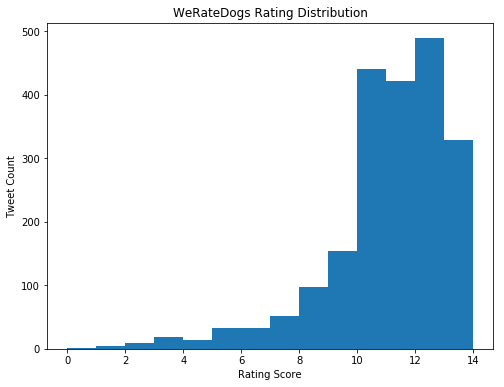

In [109]:
rating_distribution()

### Plot 2. Correlation Plot: If a tweet is retweetd a lot, is it being favorited a lot meantime?

I use basic scatter plot to visualize the correlation between retweet count and favorite count. As you can see, retweet numbers and favortie count are strongly positively correlated with a Pearson Correlation Coefficient = 0.9272. This means, with a larger count of retweet, favorite count increases. Most tweets retweeted and favorited for 20,000 and 50,000 times. The slope of fitted line interprets that people tend to favorite a twitter than retweet it.


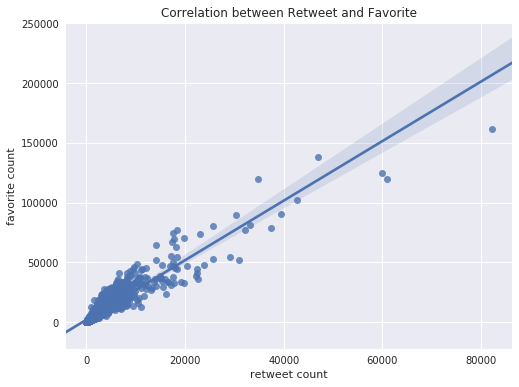

In [110]:
correlation_plot()

### Analysis on Retweet and Favorite in Predicting Rating Score Using Linear Regression:  If a tweet being retweeted and favorite a lot, does it mean it has a high rating?'

In [111]:
rating_prediction1()

                            OLS Regression Results                            
Dep. Variable:       rating_numerator   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     229.8
Date:                Sat, 22 Jun 2019   Prob (F-statistic):           6.05e-91
Time:                        23:35:29   Log-Likelihood:                -4356.8
No. Observations:                2094   AIC:                             8720.
Df Residuals:                    2091   BIC:                             8737.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          9.9793      0.052    191.

### Plot 3. Retweet/Favorite on Rating Score Plot: Will highly rated dogs cause big trend on retweet and favorite? 


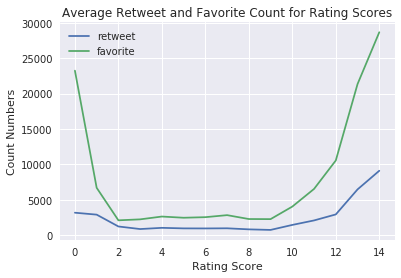

Two interesting findings from the plot: One is when the rating score is zero, favorite count reaches about 23000 which is rare. Second finding is, with rating score is 9 and above, favorite and retweet count are increasing, as rating score is increasing. Users tend to favorite a tweet rather than retweet.


In [112]:
rating_prediction2()

### Plot 4. Popularity on Three Dimensions(Retweet, Favorite and Rating) on dog stage: People like young dog better or old dog better?


I use bar plot for this multivariate exploration. pupper is the youngest dog stage and doggo is the oldest stage. As you can see, teenager dog (puppo) is most popular from all three dimensions.  The popularity towards furry dog (floofer) is neutral.


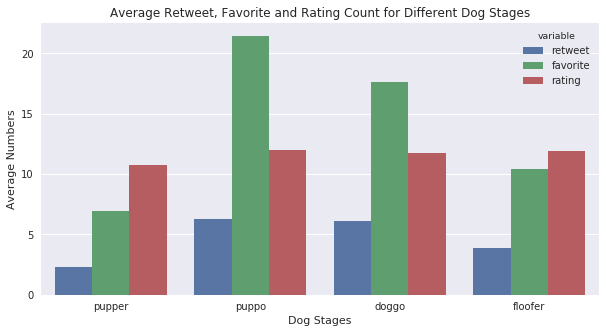

In [113]:
dogstage_plot()

### Plot 5. Where are tweets coming from?

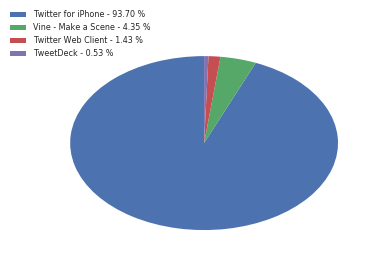

I use pie chart for this source exploration. Largest proportion for source is Twitter from iPhone to a large ratio. Other three sources: Vine, Web Client and TweetDeck share a small proportions on WeRateDogs tweet sources.


In [114]:
source_plot()

### Plot 6. What are the dog breeds that are tweeted most and rated highest on WeRateDogs?

I use bar chart for this breed ranking. As you can see, Golden Retriever, Pembroke are stars in dog breed as they appear in both ranking.


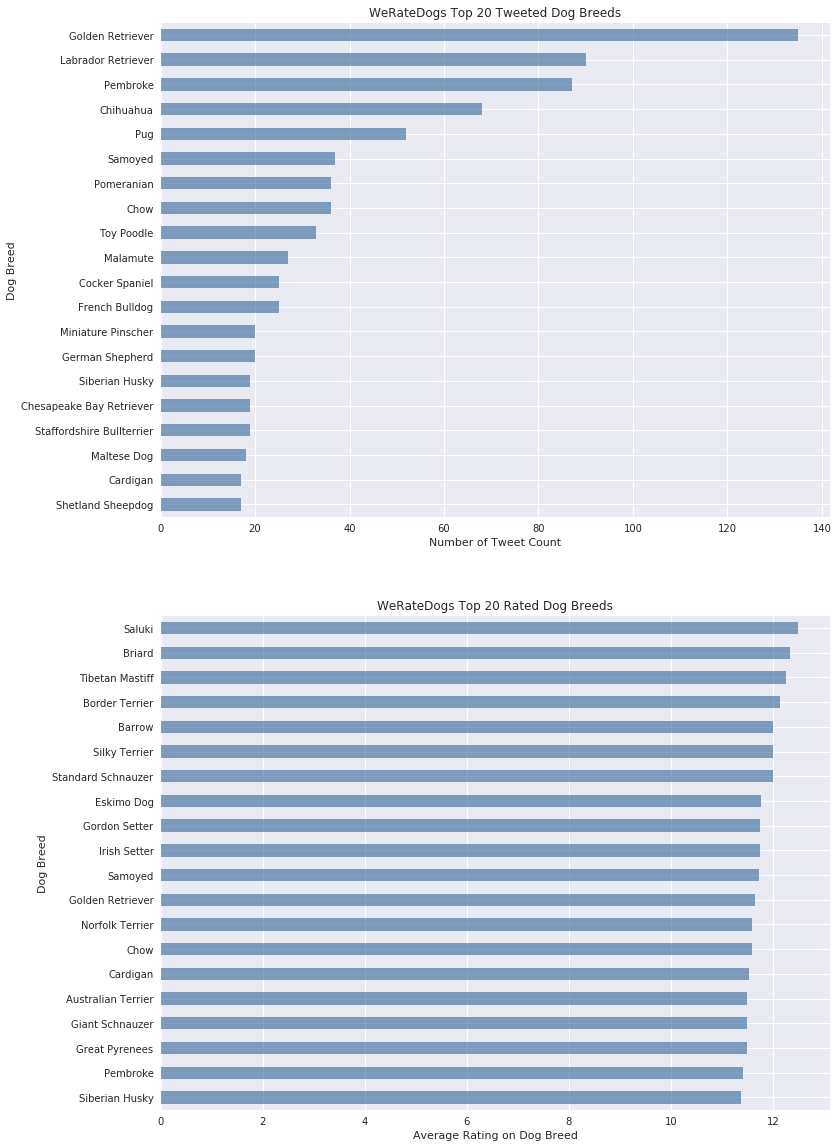

In [115]:
breed_ranking()

### Plot 7. What kinds of dog breed are confidently to predict?

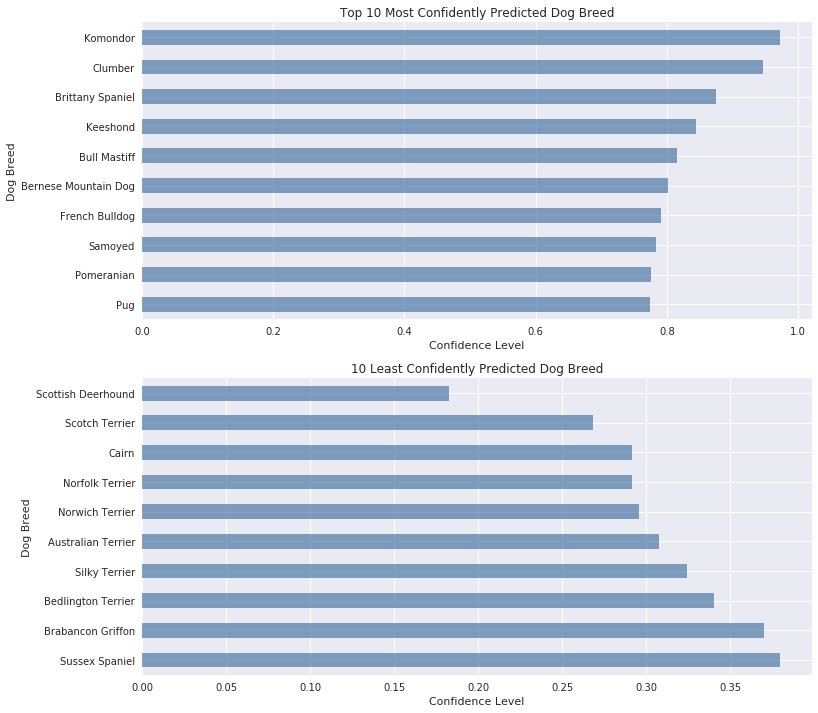

Breeds with "Terrier" are predicted with a low confidence level. 


In [116]:
prediction_ranking()

<a id='conclusions'></a>
# Conclusions

1. How does WeRateDogs rate dogs on Socres?

> There are 80% of dogs rated in the range of 10 and 13. The highest rating score is 14, involving 2% of dog pictures. Pictures could be rated to zero, due to the reason that people are not sending dog pictures. Scary dogs and not-looking-good pictures could be rated low. WeRateDogs rates dog pictures with both good and bad comments. 

2. If a tweet is retweeted a lot, is being favorited a lot meantime?

> Data shows a strong evidence that retweet count and favorite count on WeRateDogs tweets positively impact on each other. If a tweet is retweeted a lot, its favorite count is also high. Numbers on favorite count are generally greater than retweet count. People tend to favorite more than retweet.

3. If a tweet being retweeted and favorite a lot, does it mean it has a high rating?

> Number of favorite count will positively predict a rating score. That means, if number of favorite count is higher,  with retweet count holds one unit lower, rating score is higher. 

4. Will highly rated dogs cause big trend on retweet and favorite?

> If WeRateDogs rates a dog picture with 9 or above, number of retweet and favorite count will increase. 

5. People like young dog better or old dog better?

> Both users on Twitter and WeRateDogs account like teeanager dogs (puppo) the best. 

6. Where are tweets coming from?

> 93.7% of tweets are coming from iPhone. People also tweet using Vine, Web Client and TweetDeck.

7. What are the dog breeds that are tweeted most and rated highest on WeRateDogs?

> - From the most tweeted dog breed ranking: WeRateDogs rates most on picures of Golden Retriever, Labrador Retriever, Pembroke, Chihuahua and Pug.
> - From the highest rated dog breed ranking: WeRateDogs gives high rating on pictures of Saluki, Briard, Tibetan Matstiff. Border Terrier and Barrow.
> - Golden Retriever and Pembroke gain a general likability from public: lots of people raise those two breeds and they gain high rating. 

8. What kinds of dog breed are confidently to predict?

> - Using neural network, confidence level to predict Komondor, Clumber, Brittany Spaniel, Keeshond and Bull Mastiff is high, which is over 80%.
> - Breeds with 'Terrier' are not confident to predict. Those breeds have confidenct levels with 30% or below. Scottish Deerhound has the lowest confidence level, which is 18%. 

### Additional discussions on limitations:
- In cleaning process, some dog names in original dataset are missing, inaccurate and non-caplitalized. The column could be cleaned to a consistent level.
- Some of the low rating scores could be dived deeper to see what are the other reasons that those pictures are rated low.
- There are other models could be used on analysis of rating score prediction. Such as using higher order terms or categorical variables like dog breed.
- Analysis on timestamp might bring interesting findings. More time needed on this project to perform additonal analysis on Timestamp.